In [1]:
import matplotlib.pyplot as plt
import pandas as pd

## Dataset: FoodAPS National Household Food Acquisition and Purchase Survey

The dataset used is the USDA's National Household Food Acquisition and Purchase Survey (FoodAPS). It has data about
individual food purchases made by households, along with the food's health data.

The data were collected through interviews with selected households in the United States. Food acquisition was tracked
in food books, with receipts saved and barcodes of food products scanned to obtain more information.

### Observations

The dataset is relational, using a primary household dataset (`faps_household_puf.csv`) linked to item and nutrient
datasets for food at home (`faps_fahitem_puf.csv` and `faps_fahnutrients.csv`). Each row in the nutrient data frame
represents a food item acquired by a household.


In [2]:
hh_df = pd.read_csv("data/faps_household_puf.csv")

item_df = pd.read_csv("data/faps_fahitem_puf.csv")
nutrient_df = pd.read_csv("data/faps_fahnutrients.csv")

A combination of unique identifying variables was used to merge the item and nutrient datasets together. Variables that
won't be used were discarded in the resulting dataset.

The variables that were kept are: the total edible gram weight of the food item (`totgramsedible`) and the total sugar
gram weight per 100 grams of the food item (`totsug`).


In [3]:
ID_VARIABLES = ["hhnum", "eventid", "itemnum"]
REQUIRED_VARIABLES = [*ID_VARIABLES, "totgramsedible", "totsug"]

food_df = item_df.merge(nutrient_df[REQUIRED_VARIABLES], how="left", on=ID_VARIABLES)

## Data Preprocessing

### Households Dataset

The households dataset was filtered to only include households that had no guests and no change in household size
throughout the entire survey period. This ensures that the data reflects the food acquisitions made by the household
itself.


In [4]:
hh_df = hh_df[(hh_df["numguests"] == 0) & (hh_df["hhsizechange"] == 0)]

The dataset was further filtered to only include households confirmed to be participants or nonparticipants in the
Supplemental Nutrition Assistance Program (SNAP). This ensures that data is comparable between the two categories of
households.


In [5]:
import enum


class SNAPNowAdmin(enum.Enum):
    """Results from match of household members with SNAP administrative data."""

    NO_MATCH = 0
    """No match."""
    CONFIRMED_SNAP = 1
    """Match confirms SNAP participation."""
    CONFIRMED_NON_SNAP = 2
    """Match confirms SNAP nonparticipation."""
    VALID_SKIP = -996
    """Valid skip. (Consent for data matching not given.)"""


hh_df = hh_df[
    (hh_df["snapnowadmin"] == SNAPNowAdmin.CONFIRMED_SNAP.value)
    | (hh_df["snapnowadmin"] == SNAPNowAdmin.CONFIRMED_NON_SNAP.value)
]

To streamline the analysis, the categorical `snapnowadmin` variable was mapped into a binary `snap_status` variable,
assigning `1` for SNAP participants and `0` for nonparticipants.

The process is known as binary masking, which converts the status to boolean values for simplification of Pandas
operations. This also allows for easier calculation of proportions or easier use of the status as a direct mathematical
weight in later statistical modeling steps.


In [6]:
hh_df["snap_status"] = (hh_df["snapnowadmin"] == SNAPNowAdmin.CONFIRMED_SNAP.value).astype("int8")

/var/folders/6r/g5w3tmhx0tj1ygxtm4032mk40000gn/T/ipykernel_99623/347733292.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hh_df["snap_status"] = (hh_df["snapnowadmin"] == SNAPNowAdmin.CONFIRMED_SNAP.value).astype("int8")


### Food Items Dataset

The food items dataset was filtered to exclude items that are not edible (zero edible gram weight) because these items
will not be relevant. Food items with no sugar content data were also excluded to prevent them skewing the data
analysis.


In [7]:
food_df = food_df[(food_df["totgramsedible"] > 0) & (food_df["totsug"].notna())]

### Convenience Variables

To prevent recalculations, additional variables were added to the food item dataset.

- `sugar_amount`: This is the amount of sugar, in grams, per gram of food.
- `sugar_density`: This is the amount of sugar, in grams, per 100 grams of food (a convenience rename of `totsug`).


In [8]:
food_df["sugar_amount"] = (food_df["totsug"] / 100) * food_df["totgramsedible"]
food_df["sugar_density"] = food_df["totsug"]

Variables were also added to track whether food items can be considered as "high in sugar." The metric used is sourced
from the United Kingdom’s Food Standards Agency’s (FSA)
[traffic light dietary labeling system](https://www.bda.uk.com/resource/sugar.html#:~:text=maltose%20or%20sucrose.-,Reading%20food%20labels,-Nutritional%20information%20must),
which classifies any food item containing more than 22.5 grams of sugar per 100 grams of food as being "high in sugar."

- `high_sugar_status`: This is a binary masked flag for whether the food item can be considered as "high in sugar" or
  not.
- `high_sugar_amount`: This is the total edible gram weight of the food item that is considered as "high in sugar".


In [9]:
HIGH_SUGAR_THRESHOLD = 22.5

food_df["high_sugar_status"] = (food_df["totsug"] > HIGH_SUGAR_THRESHOLD).astype("int8")
food_df["high_sugar_amount"] = food_df["totgramsedible"] * food_df["high_sugar_status"]

## Exploratory Data Analysis Question 1

**_Are SNAP households more likely to acquire sugary foods than non-SNAP households?_**


### Mean Household Sugar Share

The household sugar and total edible food item weights were summed in order to calculate the household's sugar share.
The sugar share is simply the total amount of sugar, in grams, per gram of all foods.


In [10]:
hh_sugar_df = (
    food_df.groupby("hhnum")
    .agg(total_sugar_amount=("sugar_amount", "sum"), total_amount=("totgramsedible", "sum"))
    .reset_index()
)
hh_sugar_df["sugar_share"] = hh_sugar_df["total_sugar_amount"] / hh_sugar_df["total_amount"]

# Add the household number and the SNAP status back for identification and categorization.
hh_sugar_df = hh_sugar_df.merge(hh_df[["hhnum", "snap_status"]], how="left", on="hhnum")

#### Visualization

The mean of the sugar shares of participating and nonparticipating households was then visualized in a bar chart in
order to differentiate between the two categories.


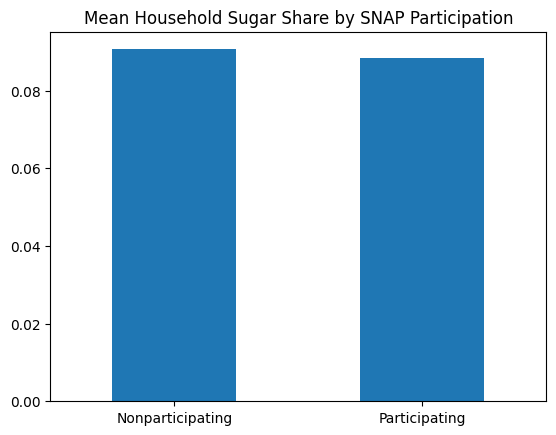

In [11]:
ax = hh_sugar_df.groupby("snap_status")["sugar_share"].mean().plot(kind="bar")

ax.set_xticks([0, 1])
ax.set_xticklabels(["Nonparticipating", "Participating"], rotation=0)

ax.set_title("Mean Household Sugar Share by SNAP Participation")
ax.set_xlabel("")

plt.show()

#### Analysis

The bar chart shows that, on average, the sugar share of food items is slightly higher for households not participating
in SNAP. This suggests that SNAP participation does not appear to be associated with acquiring more sugar-dense food
items.


### Mean Household Total Sugar Amount

#### Visualization

The mean of the total sugar amounts of participating and nonparticipating households was then visualized in a bar chart
in order to differentiate between the two categories.


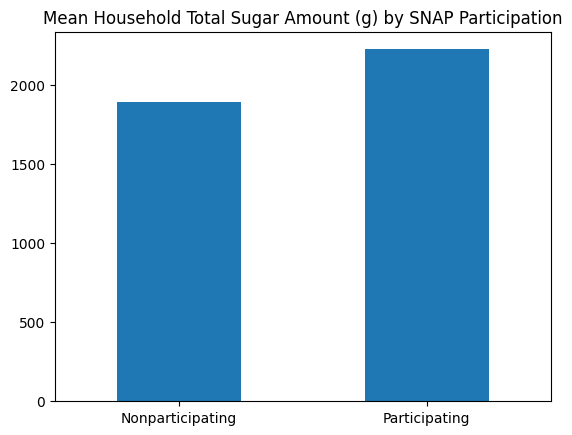

In [12]:
ax = hh_sugar_df.groupby("snap_status")["total_sugar_amount"].mean().plot(kind="bar")

ax.set_xticks([0, 1])
ax.set_xticklabels(["Nonparticipating", "Participating"], rotation=0)

ax.set_title("Mean Household Total Sugar Amount (g) by SNAP Participation")
ax.set_xlabel("")

plt.show()

#### Analysis

The bar chart shows that, on average, households participating in SNAP acquire more sugar by weight. This likely
reflects larger household sizes and/or higher overall consumption volumes. This does not indicate a preference for
sugary foods.


### Mean Household High Sugar Food Proportion

The proportion of household food items classified as "high in sugar" was then calculated using the mean of the `0` and
`1` high sugar status values of food items.


In [13]:
high_sugar_proportion_df = food_df.groupby("hhnum")["high_sugar_status"].mean().reset_index()

# Add the household number and the SNAP status back for identification and categorization.
high_sugar_proportion_df = high_sugar_proportion_df.merge(hh_df[["hhnum", "snap_status"]], on="hhnum")

#### Visualization

The mean of the high sugar proportions of participating and nonparticipating households was then visualized in a bar
chart in order to differentiate between the two categories.


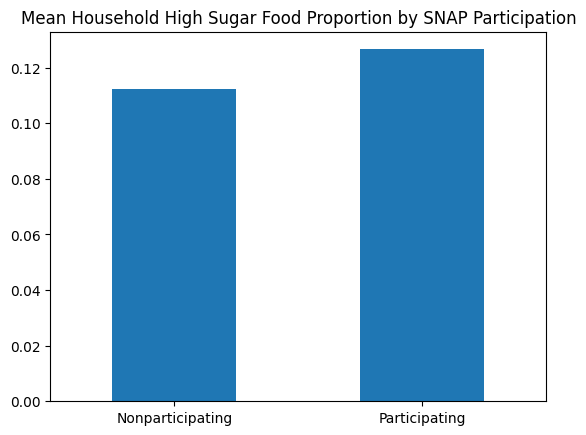

In [14]:
ax = high_sugar_proportion_df.groupby("snap_status")["high_sugar_status"].mean().plot(kind="bar")

ax.set_xticks([0, 1])
ax.set_xticklabels(["Nonparticipating", "Participating"], rotation=0)

ax.set_title("Mean Household High Sugar Food Proportion by SNAP Participation")
ax.set_xlabel("")


plt.show()

#### Analysis

The bar chart shows that, on average, the proportion of high in sugar food items is higher for SNAP participating
households. This suggests that SNAP participating households may acquire more "high in sugar" food items, but not
necessarily more sugar-dense food items.


### Distribution of Household Sugar Share

#### Visualization

The sugar shares of participating and nonparticipating households were then visualized in a box plot in order to further
differentiate between the two categories.


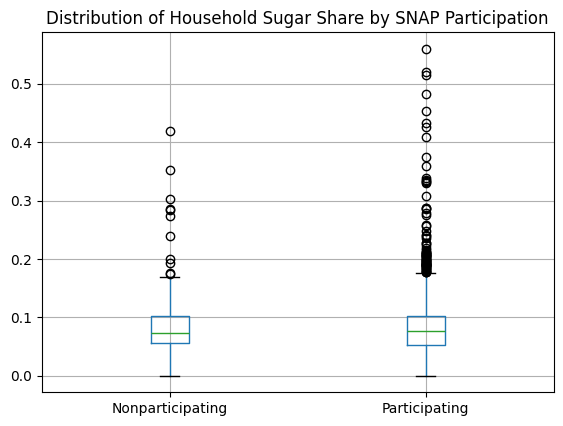

In [15]:
hh_sugar_df.boxplot(column="sugar_share", by="snap_status")

plt.xticks([1, 2], ["Nonparticipating", "Participating"])

plt.title("Distribution of Household Sugar Share by SNAP Participation")
plt.suptitle("")
plt.xlabel("")

plt.show()

#### Analysis

The box plot shows that typical households, participating or not, are nearly identical; however, a subset of SNAP
participating households acquire "high in sugar" food items more than the rest. Both groups appear to be right-skewed in
their distributions.

### Answer

There is **no strong evidence** that SNAP households systematically acquire more sugar-dense food overall. However, they
acquire more sugar in absolute terms, and they purchase a higher proportion of "high in sugar" food items.


## Exploratory Data Analysis Question 2

**_Do SNAP households exhibit greater variability in sugar density across acquired items compared to non-SNAP households?_**


The household sugar density standard deviation was then calculated; it serves as the measure of variability.


In [16]:
hh_sugar_variability_df = food_df.groupby("hhnum").agg(sugar_sd=("sugar_density", "std")).reset_index()

# Add the household number and the SNAP status back for identification and categorization.
hh_sugar_variability_df = hh_sugar_variability_df.merge(hh_df[["hhnum", "snap_status"]], how="left", on="hhnum")

### Descriptive Statistics

The household sugar density standard deviations were then described, showing counts, means, standard deviations, min,
max, and percentiles per category (SNAP participant or nonparticipant).


In [17]:
hh_sugar_variability_df.groupby("snap_status")["sugar_sd"].describe()

,count,mean,std,min,25%,50%,75%,max
snap_status,,,,,,,,
0.0,101.0,14.077620,9.525857,0.0,5.826651,12.371478,19.140549,43.906323
1.0,977.0,13.828645,9.101095,0.0,6.023803,12.728962,19.636405,66.991296


### Analysis

The statistics show that:

- The mean difference is small, suggesting that there is no meaningful difference in average sugar density between
  SNAP-participating and nonparticipating households.
- The median difference is small, suggesting that the distributions are very similar and the difference is likely due to
  outliers.
- The standard deviations and interquartile range are very close, meaning that sugar density variability across
  households is very similar between SNAP-participating and nonparticipating households.
- SNAP-participating households have higher outliers, or more high sugar density households.


### Visualization

The sugar density standard deviations of participating and nonparticipating households were then visualized in a box
plot in order to further differentiate between the two categories.


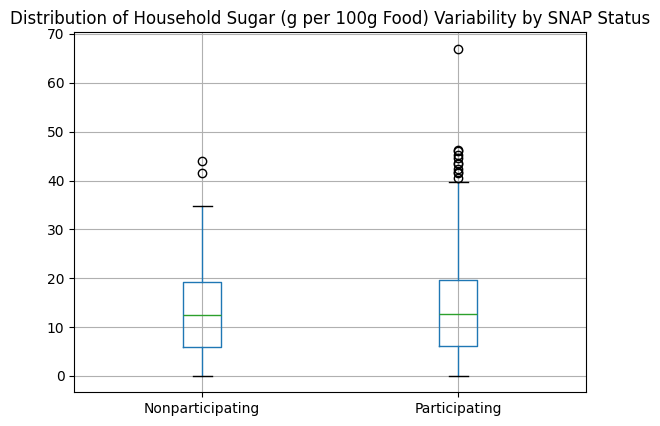

In [18]:
hh_sugar_variability_df.boxplot(column="sugar_sd", by="snap_status")

plt.xticks([1, 2], ["Nonparticipating", "Participating"])

plt.title("Distribution of Household Sugar (g per 100g Food) Variability by SNAP Status")
plt.suptitle("")
plt.xlabel("")

plt.show()

### Analysis

The box plot confirms the analysis of the descriptive statistics, that the distributions are very similar and
SNAP-participating households have more and higher outliers.

### Answer

SNAP-participating households do not display greater variability in sugar density across acquired food items. Measures
of dispersion, including standard deviation and interquartile range, are very similar, meaning that there are comparable
levels of variability.


## Exploratory Data Analysis Question 3

**_Are SNAP households more likely to have a higher share of their total acquired food coming from high-sugar items?_**


The household **high** sugar and total edible food item weights were summed in order to calculate the household's high sugar
share. The high sugar share is like the sugar share, but only accounting for food items considered as "high in sugar."


In [19]:
hh_high_sugar_df = (
    food_df.groupby("hhnum")
    .agg(total_high_sugar_amount=("high_sugar_amount", "sum"), total_amount=("totgramsedible", "sum"))
    .reset_index()
)
hh_high_sugar_df["high_sugar_share"] = hh_high_sugar_df["total_high_sugar_amount"] / hh_sugar_df["total_amount"]

# Add the household number and the SNAP status back for identification and categorization.
hh_high_sugar_df = hh_high_sugar_df.merge(hh_df[["hhnum", "snap_status"]], how="left", on="hhnum")

### Descriptive Statistics

The household high sugar shares were then described, showing counts, means, standard deviations, min, max, and
percentiles per category (SNAP participant or nonparticipant).


In [20]:
hh_high_sugar_df.groupby("snap_status")["high_sugar_share"].describe()


,count,mean,std,min,25%,50%,75%,max
snap_status,,,,,,,,
0.0,106.0,0.071885,0.131677,0.0,0.0,0.028703,0.089947,0.80627
1.0,1010.0,0.072152,0.110930,0.0,0.0,0.038587,0.093324,1.00000


### Analysis

The statistics show that:

- The mean difference is almost identical, practically zero.
- The median for SNAP-participating households is slightly higher, suggesting that more of their food items are "high in
  sugar."
- The standard deviations are very close, meaning that high sugar share variability across households is very similar
  between SNAP-participating and nonparticipating households.
- At least a quarter of SNAP-participating and nonparticipating households have not acquired "high in sugar" food items.
- Both SNAP-participating and nonparticipating households have very high outliers.

### Answer

SNAP-participating households do not display a higher share of "high in sugar" food items. Mean and distribution are
nearly identical, suggesting no meaningful difference in purchasing composition.
